In [22]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset
# import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import DetrForObjectDetection
import torch
from torch import nn
from torchvision.models import resnet50
import os
import torch.optim as optim

In [9]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Nếu bạn dùng nhiều GPU
    torch.backends.cudnn.deterministic = True  # Đảm bảo các phép toán đồng nhất
    torch.backends.cudnn.benchmark = False  # Tránh phép tối ưu hóa gây sai lệch

SEED = 42
set_seed(SEED)

: 

In [10]:
base_dir = './data/Food146K/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 2
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(
    train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(
    test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 3


: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8081232..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


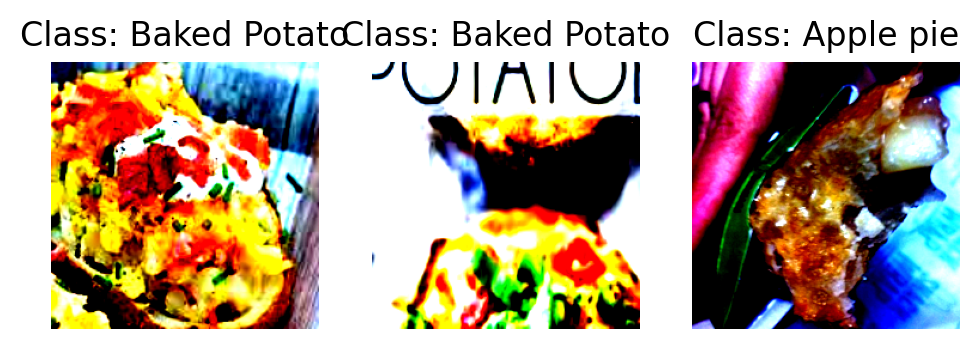

: 

In [11]:
train_iterator = iter(train_loader)
images, labels = next(train_iterator)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 5, i + 1)
    # Chuyển từ (C, H, W) sang (H, W, C)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"Class: {class_names[labels[i]]}")
    plt.axis("off")
plt.show()

In [12]:
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [21]:
config = model.config
print("before", config.num_queries, config.num_labels)
config.num_queries = 2
config.num_labels = num_classes
print("after", config.num_queries, config.num_labels)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", config=config, ignore_mismatched_sizes=True).to(DEVICE)
model.load_state_dict(torch.load('./saved_models/DETR_Classification_best.pth', map_location=DEVICE))

before 2 3
after 2 3


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

<All keys matched successfully>

: 

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

def save_model(model, model_name, best=False):
    os.makedirs("saved_models", exist_ok=True)
    suffix = "best" if best else "weights"
    save_path = os.path.join("saved_models", f"{model_name}_{suffix}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model {'best ' if best else ''}weights saved to {save_path}")


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            outputs = outputs.logits[:, 0, :]
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy


def train_model(model, train_loader, val_loader, model_name, epochs=EPOCHS, learning_rate=LEARNING_RATE):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_accuracy = 0.0  # Để theo dõi độ chính xác tốt nhất
    best_model_weights = None  # Để lưu trạng thái mô hình tốt nhất

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.logits[:, 0, :]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Kiểm tra và lưu mô hình tốt nhất
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = model.state_dict().copy()
            save_model(model, model_name, best=True)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # Lưu mô hình cuối cùng (không phải tốt nhất)
    save_model(model, model_name, best=False)

    # Tải lại weights của best model vào mô hình
    if best_model_weights:
        model.load_state_dict(best_model_weights)

    return train_losses, val_losses, val_accuracies, best_accuracy

In [24]:
train_losses, val_losses, val_accuracies, best_accuracy = train_model(
    model, train_loader, val_loader, "DETR_Classification")
print(best_accuracy)

Model best weights saved to saved_models\DETR_Classification_best.pth
Epoch 1/2, Train Loss: 1.3151, Val Loss: 1.2747, Val Accuracy: 66.67%
Epoch 2/2, Train Loss: 1.2111, Val Loss: 1.2222, Val Accuracy: 66.67%
Model weights saved to saved_models\DETR_Classification_weights.pth
66.66666666666667


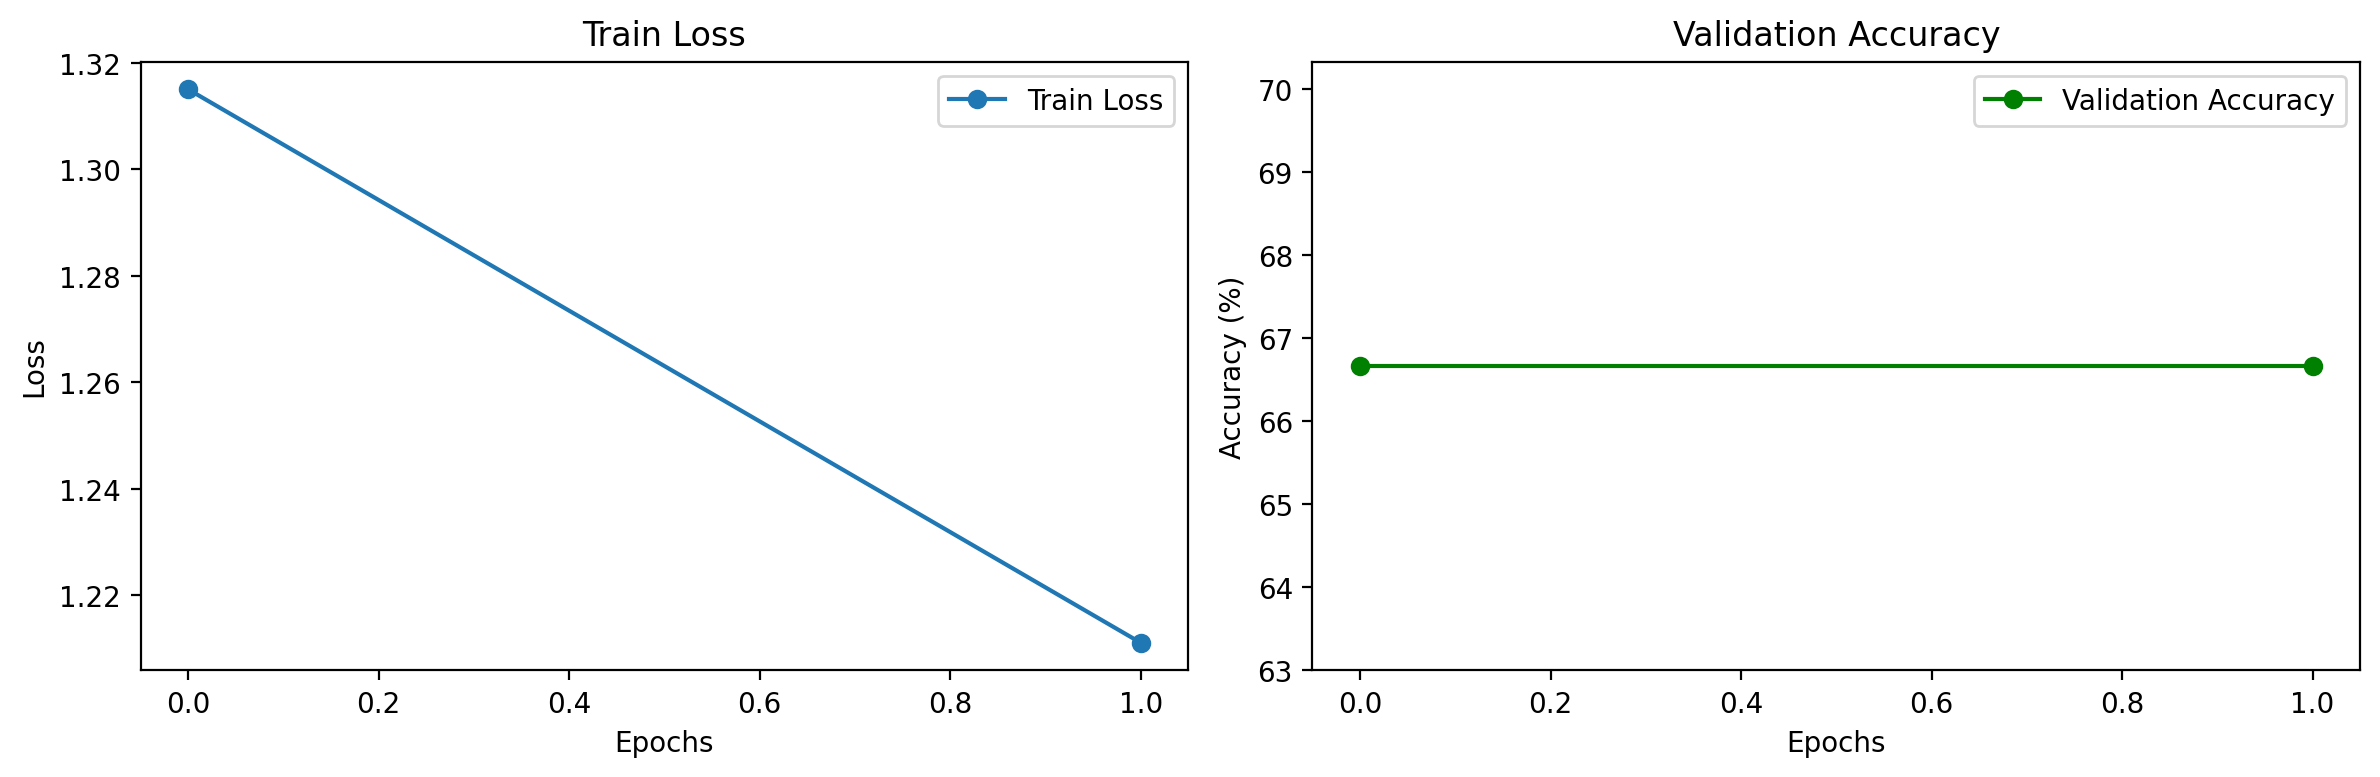

In [25]:
import matplotlib.pyplot as plt

# Giả sử bạn đã có train_losses, val_losses, và val_accuracies từ train_model()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột cho 2 biểu đồ

# Train Loss
axes[0].plot(train_losses, label="Train Loss", marker="o")
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Validation Accuracy
axes[1].plot(val_accuracies, label="Validation Accuracy",
             marker="o", color="green")
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [26]:
test_loss, test_accuracy = validate_model(
    model, test_loader, nn.CrossEntropyLoss())
test_accuracy

66.66666666666667

In [27]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled


def plot_results(pil_img, prob):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)

    cl = prob.argmax()
    if cl == num_classes:
        text = f'No object : {prob[cl]:0.2f}'
    else:
        text = f'{class_names[cl]}: {prob[cl]:0.2f}'
    plt.title(text, fontsize=14)  # Thêm title hiển thị kết quả
    plt.axis('off')  # Tắt trục tọa độ
    plt.show()

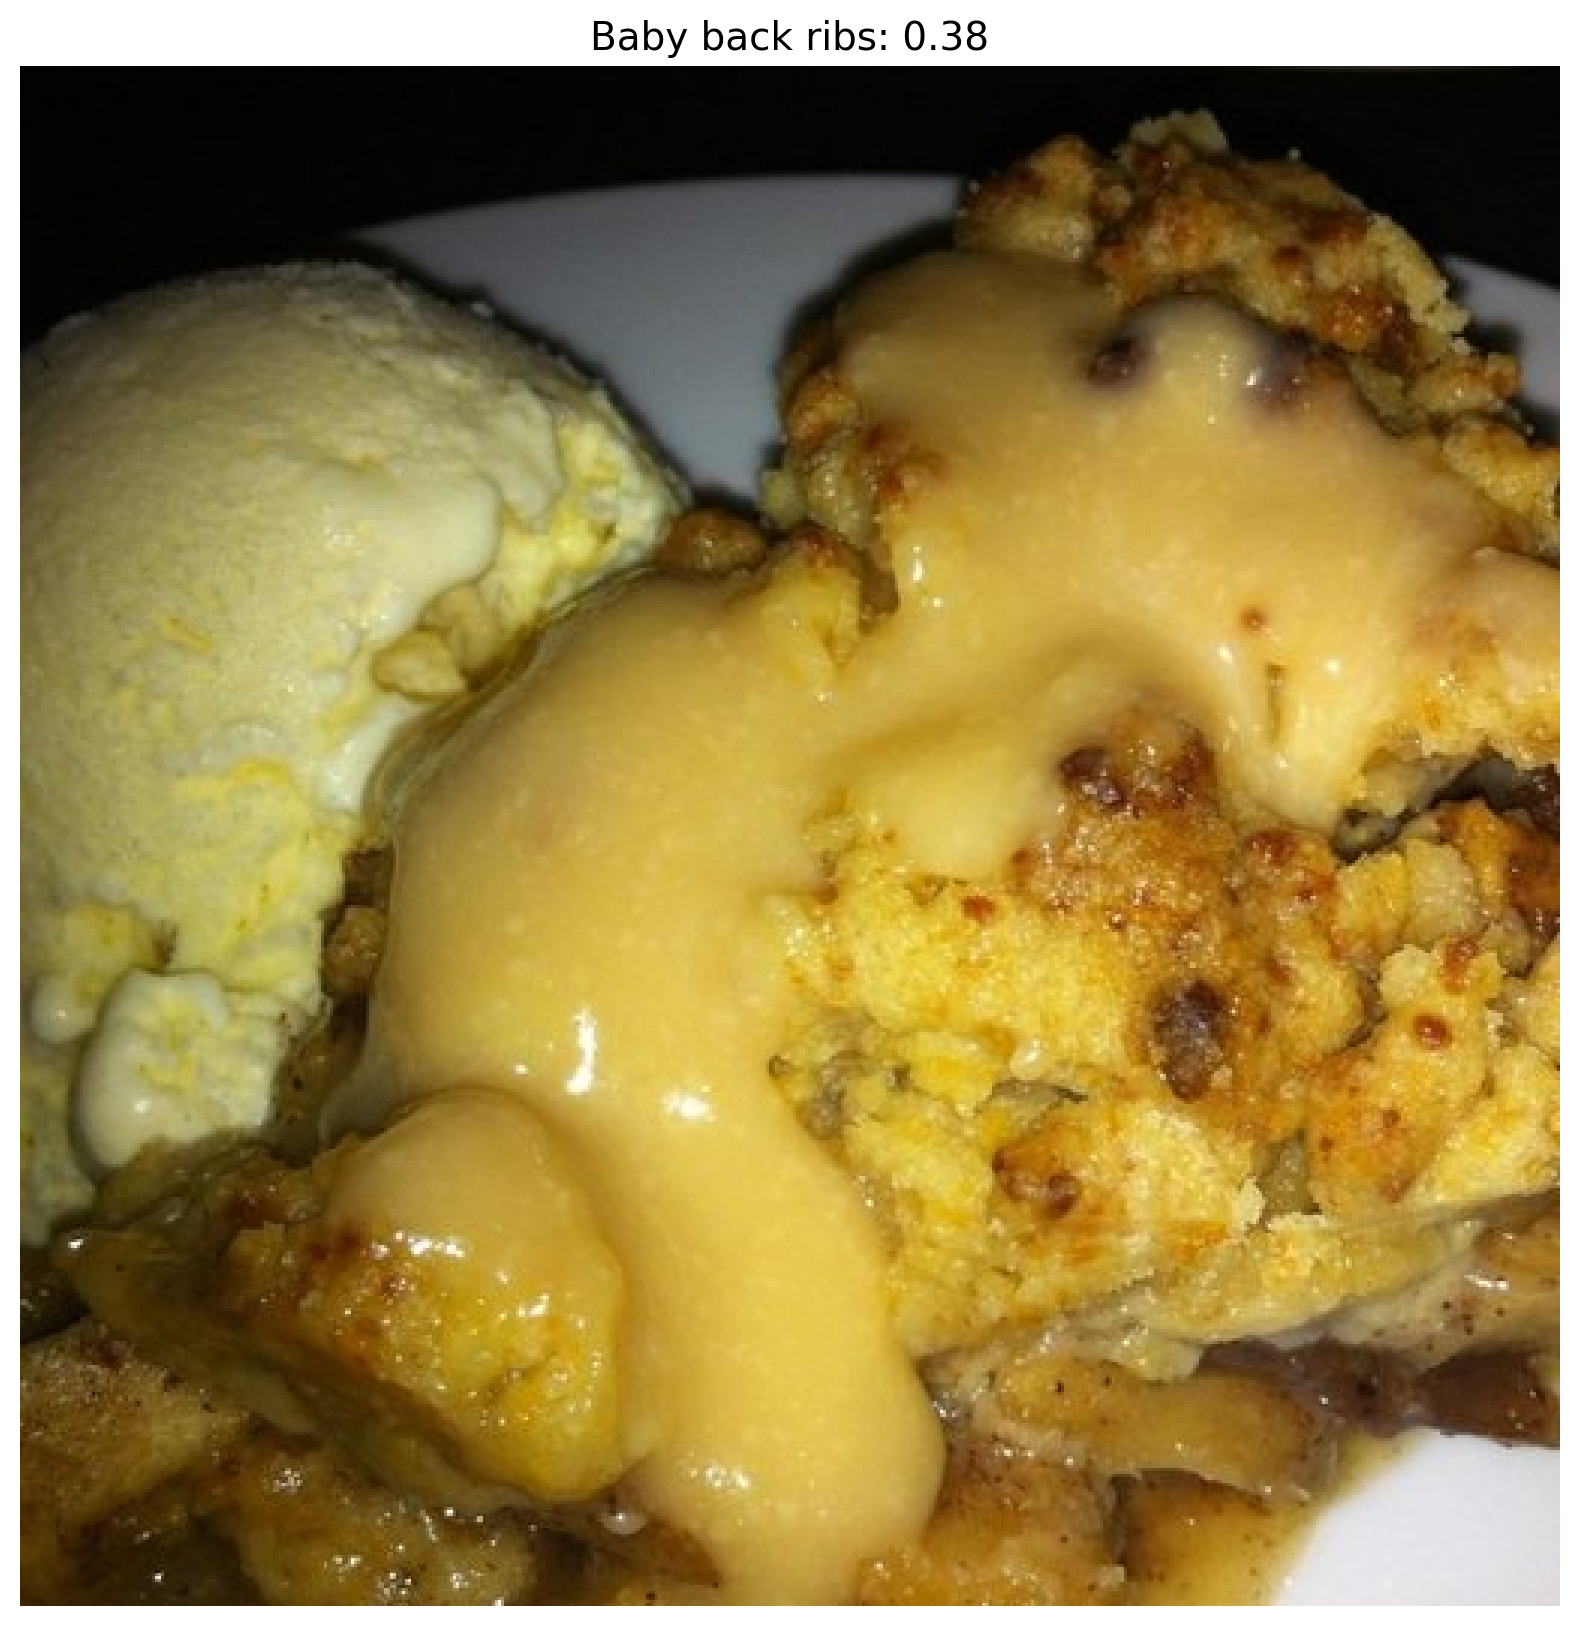

In [30]:
img = Image.open('./data/Food146K/test/Apple pie/020.jpg')
img = data_transforms['test'](img).unsqueeze(0)  # (1, C, H, W)
img = img.to(DEVICE)
outputs = model(img)
probas = outputs.logits.softmax(-1)[0, :, :-1]
plot_results(Image.open('./data/Food146K/test/Apple pie/020.jpg'),
             probas.max(-1).values)